# Prerequisites

In [1]:
import scanpy.api as sc
import numpy as np
import pandas as pd
import MulticoreTSNE
import seaborn as sb
import matplotlib.pyplot as plt
import os
import glob
import scrublet as scr
import bbknn
import re
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
sc.logging.print_versions()

/home/icb/subarna.palit/tmp/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


# Load raw data
# Importing gene stable ID:gene name mapping from BiomaRt

In [2]:
dat = pd.read_csv('./counts_inex_down-text.txt',index_col=0).T
adata_scrb = sc.AnnData(dat)
mart = pd.read_csv('./mart_export_new_version.txt', sep='\t', index_col = 0)
adata_scrb.var_names = [str(mart.loc[name].values[0]) if name in mart.index.values else name for name in adata_scrb.var_names]
adata_scrb.var_names
adata_scrb.var = adata_scrb.var.reindex(adata_scrb.var.index)
# Making gene names unique
adata_scrb.var_names_make_unique()

(180, 20126)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Index(['ccdc80', 'nrf1', 'ube2h', 'slc9a3r1a', 'dap', 'itsn1', 'myh10',
       'tmem267', 'thraa', 'itsn2a',
       ...
       'CABZ01078767.1', 'BX000463.2', 'CR926130.2', 'BX511073.1',
       'BX908750.2', 'BX323593.1', 'BX537296.5', 'CABZ01064670.1',
       'CR385041.1', 'GFP'],
      dtype='object', length=20126)

# Quality control

In [5]:
# Basic filtering
sc.pp.filter_cells(adata_scrb, min_genes=200)
sc.pp.filter_genes(adata_scrb, min_cells=3)
adata_scrb.shape

(180, 15578)

In [6]:
# Calculating QC metrics
adata_scrb.obs['n_counts'] = adata_scrb.X.sum(axis=1)
adata_scrb.obs['log_counts'] = np.log(adata_scrb.obs['n_counts'])

adata_scrb.obs['n_genes'] = (adata_scrb.X > 0).sum(axis = 1)
# Calculate percentage of mitochondrial genes expressed in each cell
mito_genes = [name for name in adata_scrb.var_names if name.startswith('mt-')]
adata_scrb.obs['mt_frac'] = np.sum(adata_scrb[:, mito_genes].X, axis=1) / np.sum(adata_scrb.X, axis=1)
mito_genes

['mt-nd1',
 'mt-nd2',
 'mt-co1',
 'mt-co2',
 'mt-atp8',
 'mt-atp6',
 'mt-co3',
 'mt-nd3',
 'mt-nd4l',
 'mt-nd5',
 'mt-nd6',
 'mt-cyb']

In [2]:
sc.pl.scatter(adata_scrb, 'n_counts', 'n_genes', color='mt_frac', size = 100)
sc.pl.scatter(adata_scrb[adata_scrb.obs['n_counts']>10000], 'n_counts', 'n_genes', color='mt_frac', size = 100)
sc.pl.scatter(adata_scrb[adata_scrb.obs['n_counts']<20000], 'n_counts', 'n_genes', color='mt_frac', size = 100)
sc.pl.scatter(adata_scrb[adata_scrb.obs['n_genes']<2000], 'n_counts', 'n_genes', color='mt_frac', size = 100)

p1 = sb.distplot(adata_scrb.obs['n_counts'], kde=False)
plt.show()
p2 = sb.distplot(adata_scrb.obs['n_counts'][adata_scrb.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

p3 = sb.distplot(adata_scrb.obs['n_genes'], kde=False, bins=60)
plt.show()
p4 = sb.distplot(adata_scrb.obs['n_genes'][adata_scrb.obs['n_genes']<2000], kde=False, bins=60)
plt.show()
p5 = sb.distplot(adata_scrb.obs['n_genes'][adata_scrb.obs['n_genes']>2000], kde=False, bins=60)
plt.show()

In [9]:
# Filtering cells based on defined thresholds
sc.pp.filter_cells(adata_scrb, max_counts = 30000)
print('Number of cells after max count filter: {:d}'.format(adata_scrb.n_obs))

sc.pp.filter_cells(adata_scrb, min_genes = 1250)
print('Number of cells after gene filter: {:d}'.format(adata_scrb.n_obs))

sc.pp.filter_cells(adata_scrb, max_genes=6000)
print('Number of cells after gene filter: {:d}'.format(adata_scrb.n_obs))

adata_scrb.shape

Number of cells after max count filter: 178
Number of cells after gene filter: 176
Number of cells after gene filter: 176


(176, 15578)

# Supplementary figure 4A

In [1]:
# Plotting data quality control summary figures
sc.pl.violin(adata_scrb, ['n_genes', 'n_counts', 'mt_frac'], jitter=0.6, multi_panel=True)

In [3]:
adata_scrb.obs["emx2_exp"] = adata_scrb[:,'emx2'].X
adata_scrb.obs['emx2_exp'] = ['1' if exp > 0 else '0' for exp in adata_scrb.obs['emx2_exp']]

In [18]:
# [name for name in adata_scrb.var_names if name.startswith('mt-')]

# Loading plate and mutant information

In [4]:
p2 = pd.read_csv('./p2_cond_1to6_bc.txt').append(pd.read_csv('./p2_cond_7to12_bc.txt'))
p4 = pd.read_csv('./p4_cond_1to6_bc.txt').append(pd.read_csv('./p4_cond_7to12_bc.txt'))
adata_scrb.obs['plate_info'] = pd.Series(['p2','p4'], dtype="category")
adata_scrb.obs['plate_info'][adata_scrb.obs.index.isin(p2.x)] = 'p2'
adata_scrb.obs['plate_info'][adata_scrb.obs.index.isin(p4.x)] = 'p4'

# Adding mutant information as metadata
emx2LOF = pd.read_csv('./condition_1_6_bc.txt')
WT = pd.read_csv('./condition_7_12_bc.txt')

adata_scrb.obs['mutant'] = pd.Series(['WT','emx2LOF'], dtype="category")
adata_scrb.obs['mutant'][adata_scrb.obs.index.isin(WT.x)] = 'WT'
adata_scrb.obs['mutant'][adata_scrb.obs.index.isin(emx2LOF.x)] = 'emx2LOF'
adata_scrb.obs

# Main figure 4A

In [ ]:
# Plotting split violin for selected genes across mutant condition
geneset = ['cldnb','eya1','emx2','atoh1a', 'myo6b', 'pvalb8', 's100t','pou4f3']
df = pd.DataFrame()
use_raw = True
new_gene_names = []
for g in geneset:
    if adata.raw is not None and use_raw:
        X_col = adata.raw[:, g].X
#    if issparse(X_col): X_col = X_col.toarray().flatten()
    new_gene_names.append(g)
    df[g] = X_col
df['hue'] = adata.obs['mutant'].astype(str).values
df['hue'] = df['hue'].astype('category')
df_tidy = pd.melt(df, id_vars='hue', value_vars=new_gene_names)

x = 'variable'
y = 'value'
f = plt.figure(figsize=(8,5))
ax = sb.violinplot(x=x, y=y, data=df_tidy, hue='hue', split=True, palette = 'colorblind', jitter = True, frameon = False)
ax.set_xlabel('')
ax.legend(title='condition')
ax.set_ylabel('log-normalised expression')
ax.grid(False)
ax.set_xticklabels(new_gene_names)
# plt.box(on=None)
sb.despine(left=False, bottom=False, right=True)


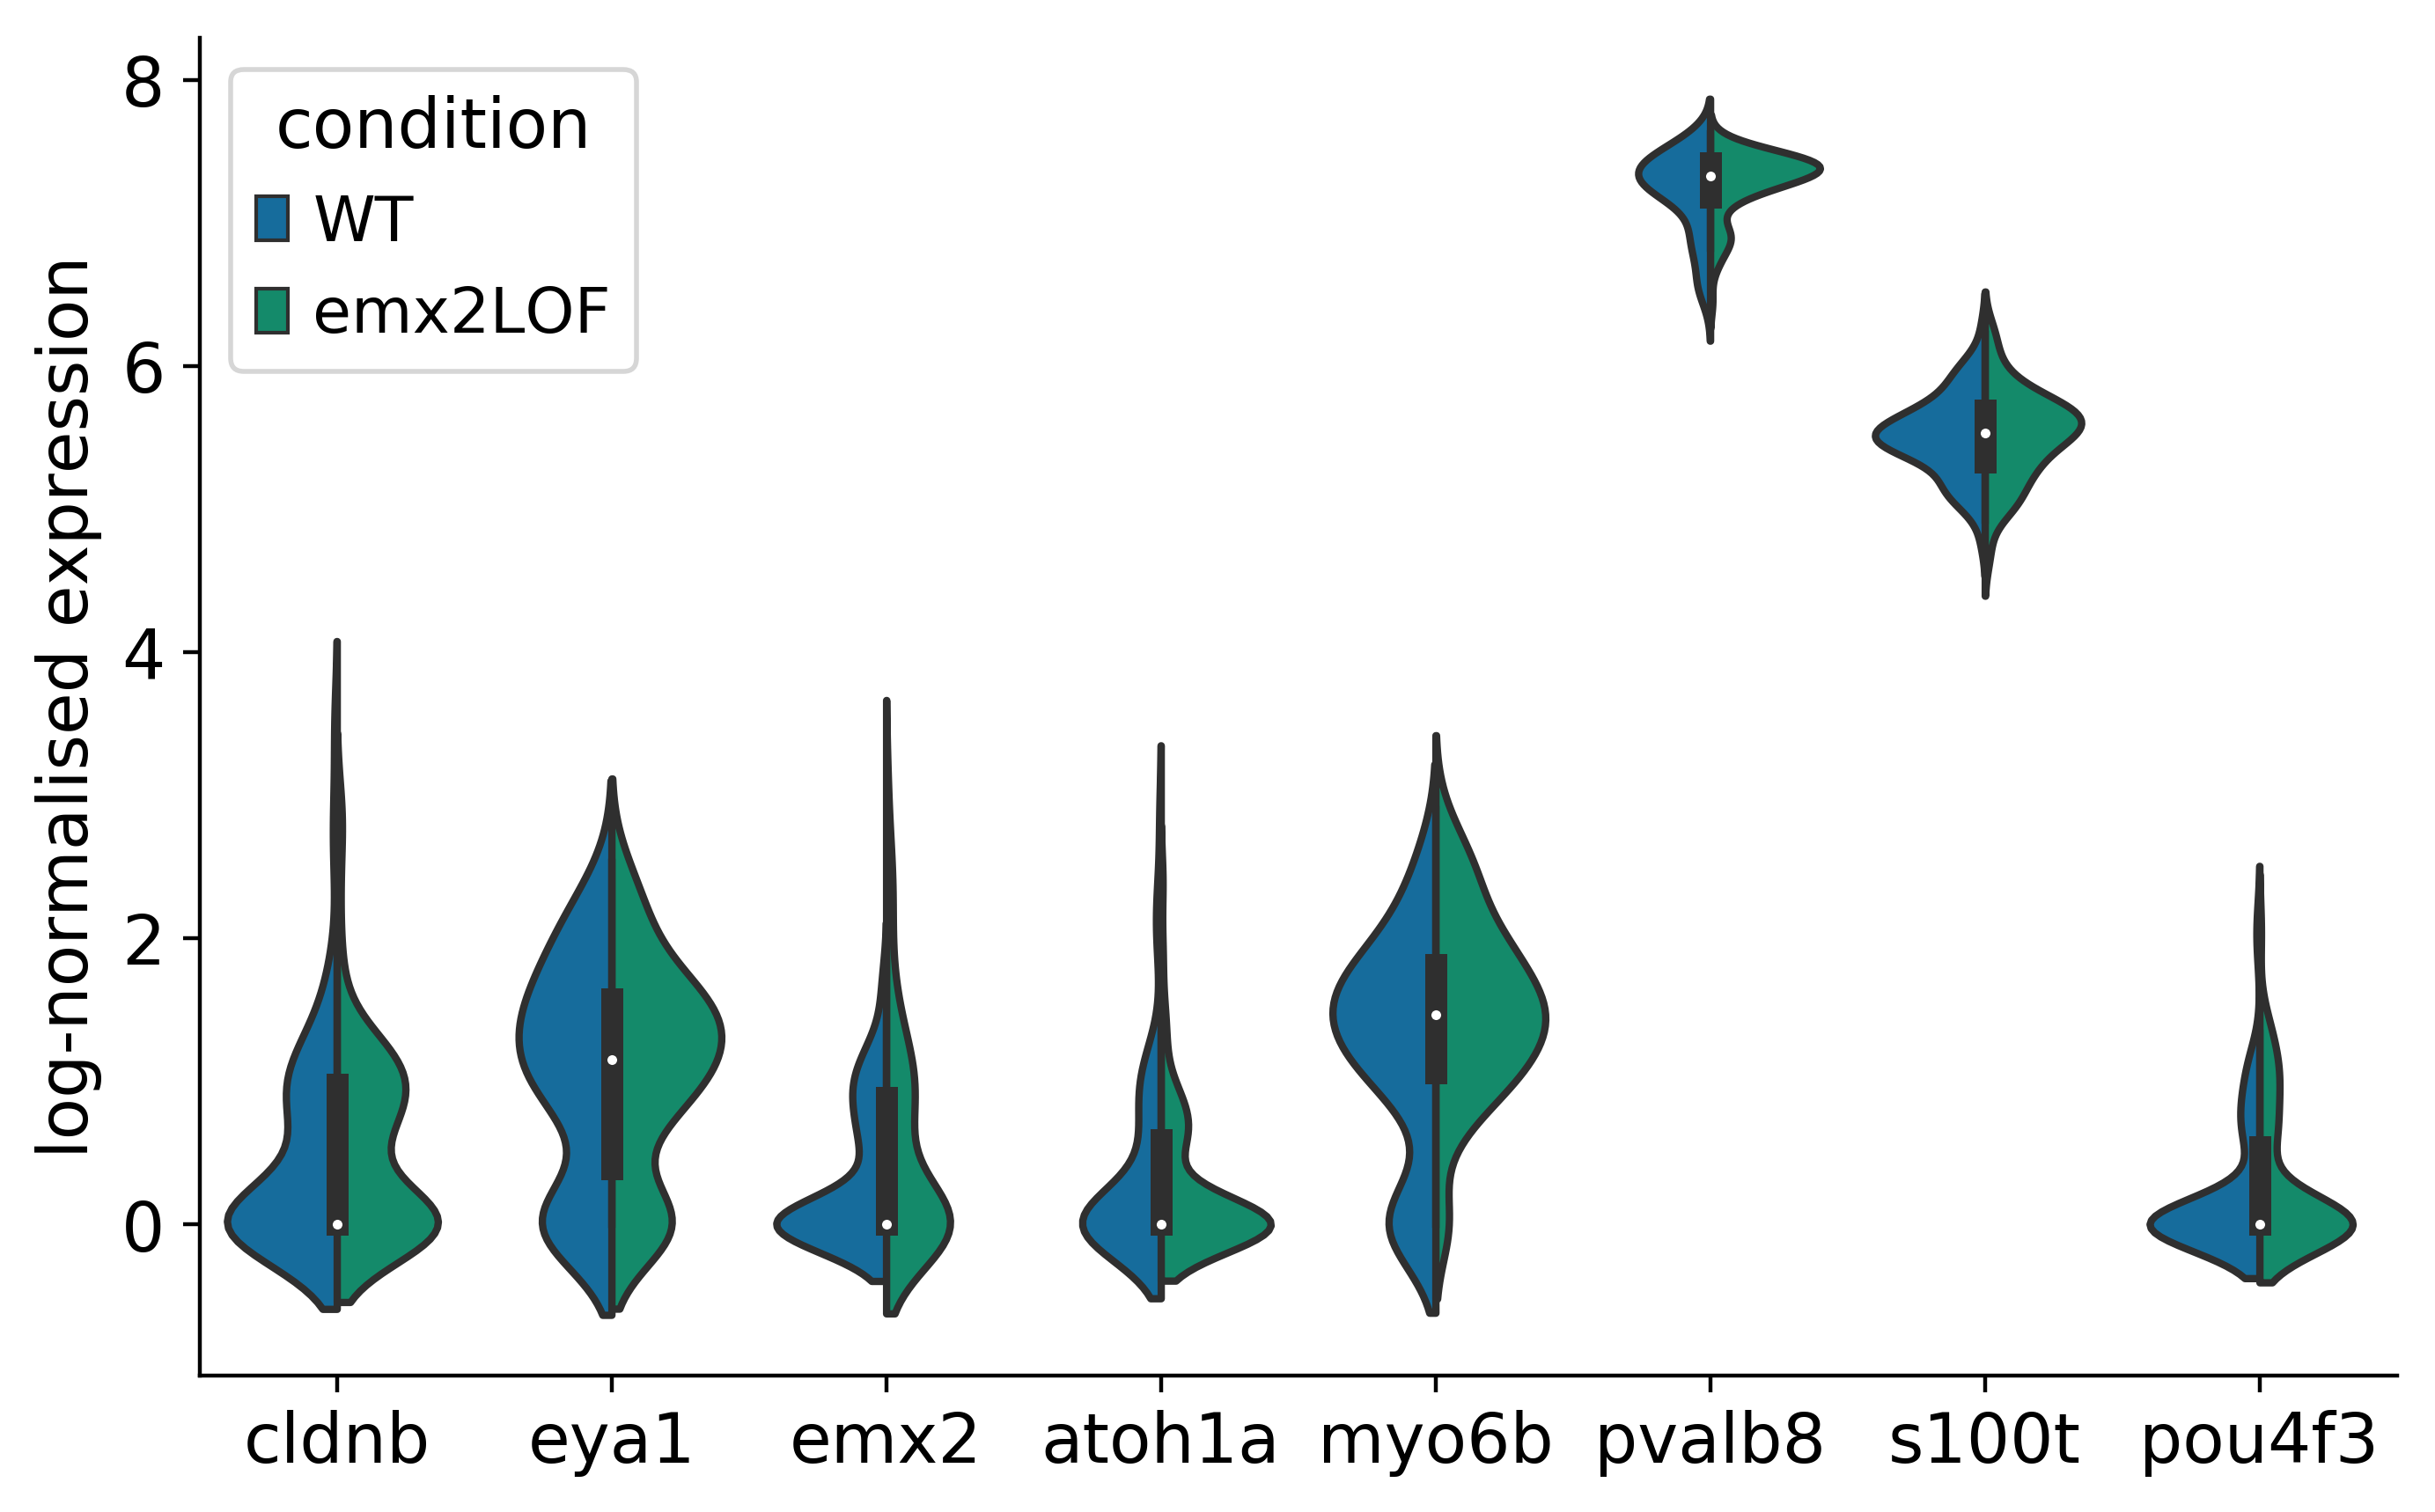

# Loading 10X neuromast data

In [6]:
adata_10x = sc.read("/home/icb/subarna.palit/projects/data_analyses/10x_Zebrafish_Hair_Support_LopezSchier/merged_adata_hair_support_cells_annotated.h5ad")

In [26]:
# Reverting log-normalised counts back to raw
adata_10x.X = adata_10x.layers['counts'].A

In [5]:
adata_scrb.obs['dataset'] = 'mcSCRBseq'
adata_scrb.obs.head()
adata_10x.obs['dataset'] = '10X'
adata_10x.obs.head()

In [28]:
adata_10x.obs["emx2_exp"] = adata_10x.raw[:,'emx2'].X
adata_10x.obs['emx2_exp'] = ['1' if exp > 0 else '0' for exp in adata_10x.obs['emx2_exp']]

/home/icb/subarna.palit/tmp/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


In [29]:
# Merge mcSCRBseq with 10X
# Outer join since number of genes do not match
merged_ad = adata_scrb.concatenate(adata_10x, join='outer')
merged_ad

AnnData object with n_obs × n_vars = 1343 × 19982 
    obs: 'batch', 'dataset', 'doublet_scores', 'emx2_exp', 'log_counts', 'louvain', 'mt_frac', 'mutant', 'n_counts', 'n_genes', 'plate_info', 'sample'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable_genes-1', 'expression_mean-1', 'dispersion-1'

In [7]:
# Replacing nans with zeros
merged_ad.X = np.array(pd.DataFrame(merged_ad.X).fillna(0))

In [33]:
# The remaining UMI counts are then log normalized
merged_ad.layers["counts"] = merged_ad.X.copy()
sc.pp.normalize_per_cell(merged_ad, counts_per_cell_after=1e4)
sc.pp.log1p(merged_ad)
merged_ad.raw = merged_ad

In [8]:
# Calculating highly variable genes
disp_filter = sc.pp.filter_genes_dispersion(merged_ad.X, flavor='cell_ranger',
                                                min_mean=0.001, n_top_genes=4000, log=False)

print('Number of highly variable genes: {:d}'.format(merged_ad[:, disp_filter['gene_subset']].n_vars))
merged_ad.var['highly_variable_genes'] = disp_filter['gene_subset']
merged_ad.var['expression_mean'] = disp_filter['means']
merged_ad.var['dispersion'] = disp_filter['dispersions']
sc.pl.filter_genes_dispersion(disp_filter)
merged_ad.var.head()

In [35]:
import bbknn
sc.pp.pca(merged_ad, svd_solver='arpack')
bdata = bbknn.bbknn(merged_ad, batch_key='dataset',copy=True, n_pcs = 60)

In [9]:
sc.set_figure_params(dpi = 150, frameon = False)
sc.tl.umap(bdata)
bdata.uns['dataset_colors'] = ['#D2691E','#40D0E0']
sc.pl.umap(bdata,color=['dataset'], wspace = 0.4)

In [10]:
sc.pl.umap(bdata,color=['emx2_exp','louvain','mutant','plate_info'], wspace = .3)

In [1]:
bdata.obs['louvain'].cat.categories
to_compare = bdata[np.isin(bdata.obs['louvain'],['young HCs'])].copy()
to_compare

In [2]:
sc.tl.rank_genes_groups(to_compare, groupby = 'emx2_exp', n_genes=200,)
result = to_compare.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges','pvals_adj','scores']})

# Split violin plots showing the expression of DE genes between young wt hair cells expressing Emx2 and young wt hair cells, with undetected Emx2 (adjusted pvalue<0,01)
# Supplementary figure 2G

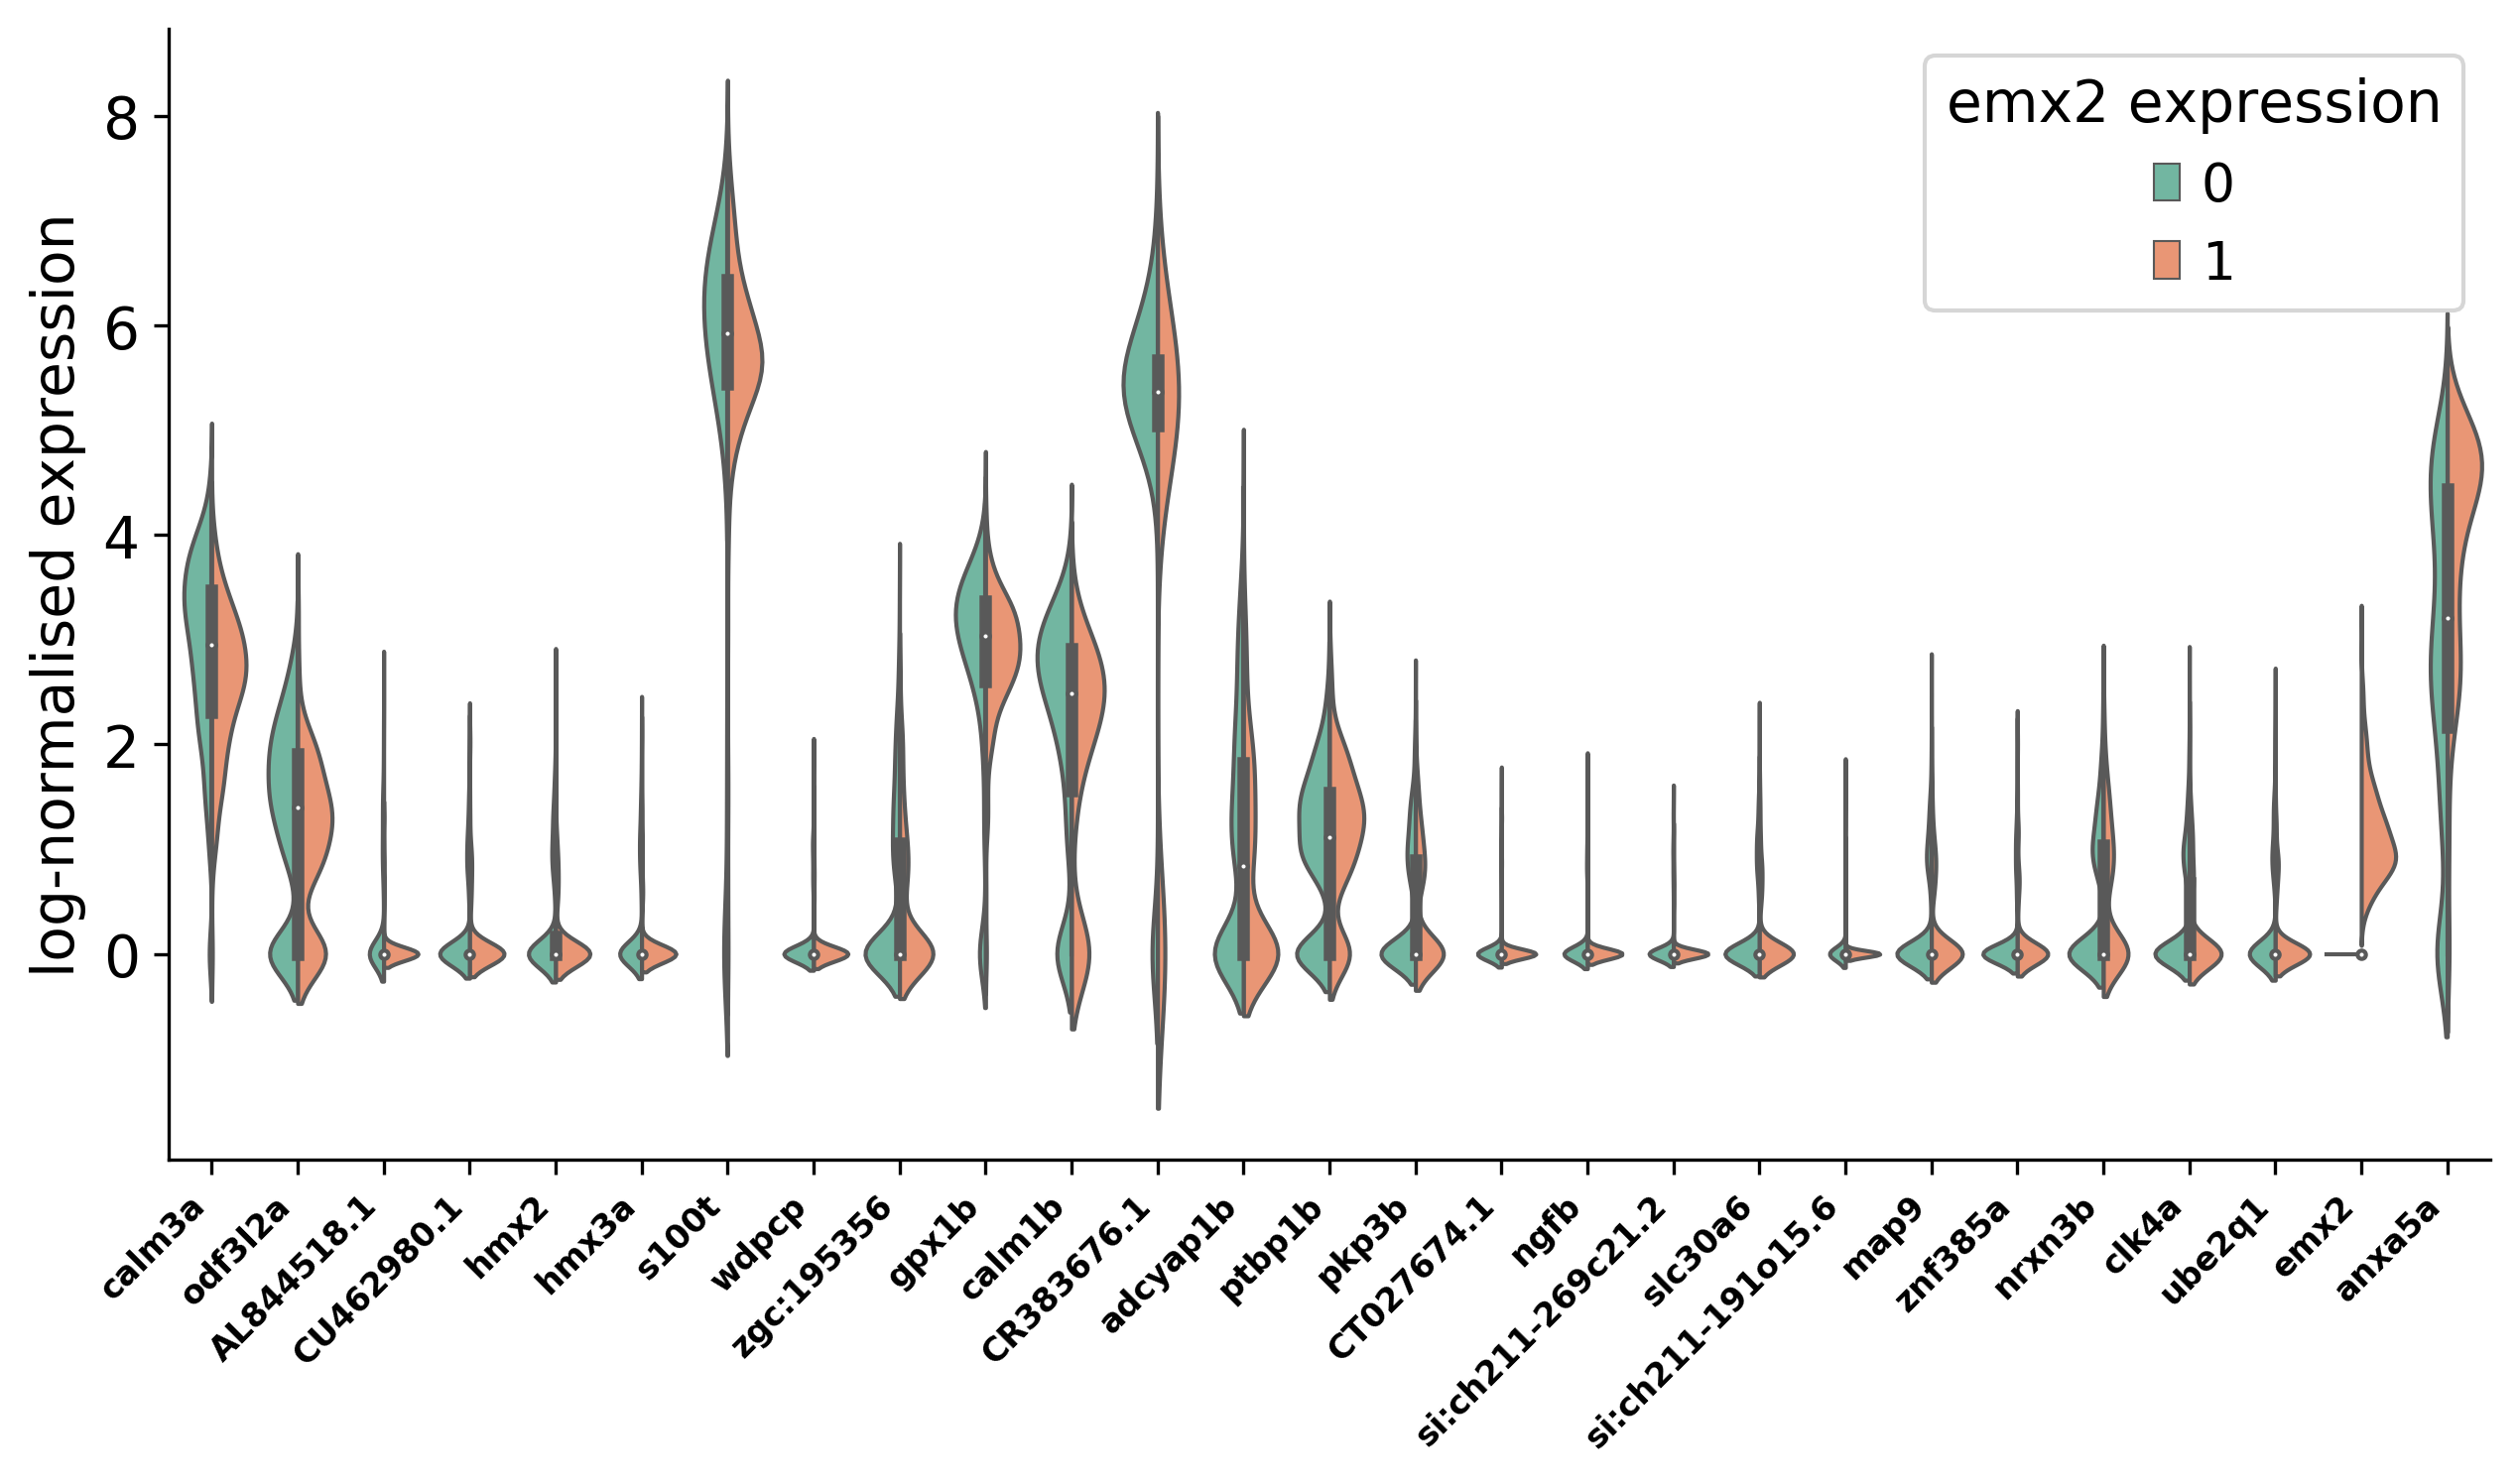

In [89]:
df = pd.DataFrame()
use_raw = True
new_gene_names = []
for g in genelist:
    if to_compare.raw is not None and use_raw:
        X_col = to_compare.raw[:, g].X
#    if issparse(X_col): X_col = X_col.toarray().flatten()
    new_gene_names.append(g)
    df[g] = X_col
df['hue'] = to_compare.obs['emx2_exp'].astype(str).values
df['hue'] = df['hue'].astype('category')
df_tidy = pd.melt(df, id_vars='hue', value_vars=new_gene_names)

x = 'variable'
y = 'value'
f = plt.figure(figsize=(10,5))
ax = sb.violinplot(x=x, y=y, data=df_tidy, hue='hue', split=True, palette = 'Set2', jitter = True, frameon = False, linewidth=1,)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',
    fontweight='bold',
    fontsize=8)
ax.legend(title='emx2 expression')
ax.set_ylabel('log-normalised expression')
ax.grid(False)
ax.set_xticklabels(new_gene_names)
# plt.box(on=None)
sb.despine(left=False, bottom=False, right=True)